Here our task is to predict whether customer would exit or not based on the data from Kaggle. (https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction) <br>
<br>
This was done in following steps:

1. Understanding the data

2. Tranforming the features (feature engineering)

3. Modeling for classification (Prediction)

We started the task by importing necessary libraries

In [165]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from datetime import datetime
from sklearn.linear_model import LogisticRegressionCV
import xgboost  as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from lightgbm import LGBMClassifier
from mlxtend.classifier import StackingCVClassifier
import lightgbm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Understanding the data

In [2]:
# importing Data
df = pd.read_csv('/Users/wootaekkim/Desktop/youtube learning/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


In [4]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

To begin with, as Rownumber, CustomerId, Surname are unneccesary for the prediction, drop these columns.

In [5]:
df.drop(['RowNumber', 'CustomerId','Surname'], axis = 1, inplace = True)

In [6]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [8]:
numeric = ['int64', 'float64']
not_numeric = ['object']
qualitative = []
quantitative = []

for col in df.columns:
    if df[col].dtype in numeric:
        quantitative.append(col)
    elif df[col].dtype in not_numeric:
        qualitative.append(col)

print('number of quantitative features: ', len(quantitative))
print('quantitative features are: ')
print(quantitative)
print('_____________________________________')
print(' ')
print('number of quantitative features: ', len(qualitative))
print('qualitative features are: ')
print(qualitative)

number of quantitative features:  9
quantitative features are: 
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
_____________________________________
 
number of quantitative features:  2
qualitative features are: 
['Geography', 'Gender']


In [9]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Check unique values of each quantiative and qualitative features

In [10]:
for col in quantitative:
    print('number of unique values of ', col, ': ', len(df[col].unique()))
    print(' ')
    print('unique values are: ')
    print(df[col].unique())
    print('_____________________________________________________________')

number of unique values of  CreditScore :  460
 
unique values are: 
[619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771
 681 544 696 766 727 693 557 531 498 651 791 733 811 707 714 782 775 799
 602 744 588 747 583 627 731 629 438 642 806 474 559 429 680 749 734 644
 626 649 805 718 840 630 654 762 568 613 522 737 648 44

In [11]:
for col in qualitative:
    print('number of unique values of ', col, ': ', len(df[col].unique()))
    print(' ')
    print('unique values are: ')
    print(df[col].unique())
    print('_____________________________________________________________')

number of unique values of  Geography :  3
 
unique values are: 
['France' 'Spain' 'Germany']
_____________________________________________________________
number of unique values of  Gender :  2
 
unique values are: 
['Female' 'Male']
_____________________________________________________________


Now check correlations between variables (feature and target)

/var/folders/cy/j205pskx0zx83x7sz14l4jhw0000gn/T/ipykernel_42062/2605090071.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot: >

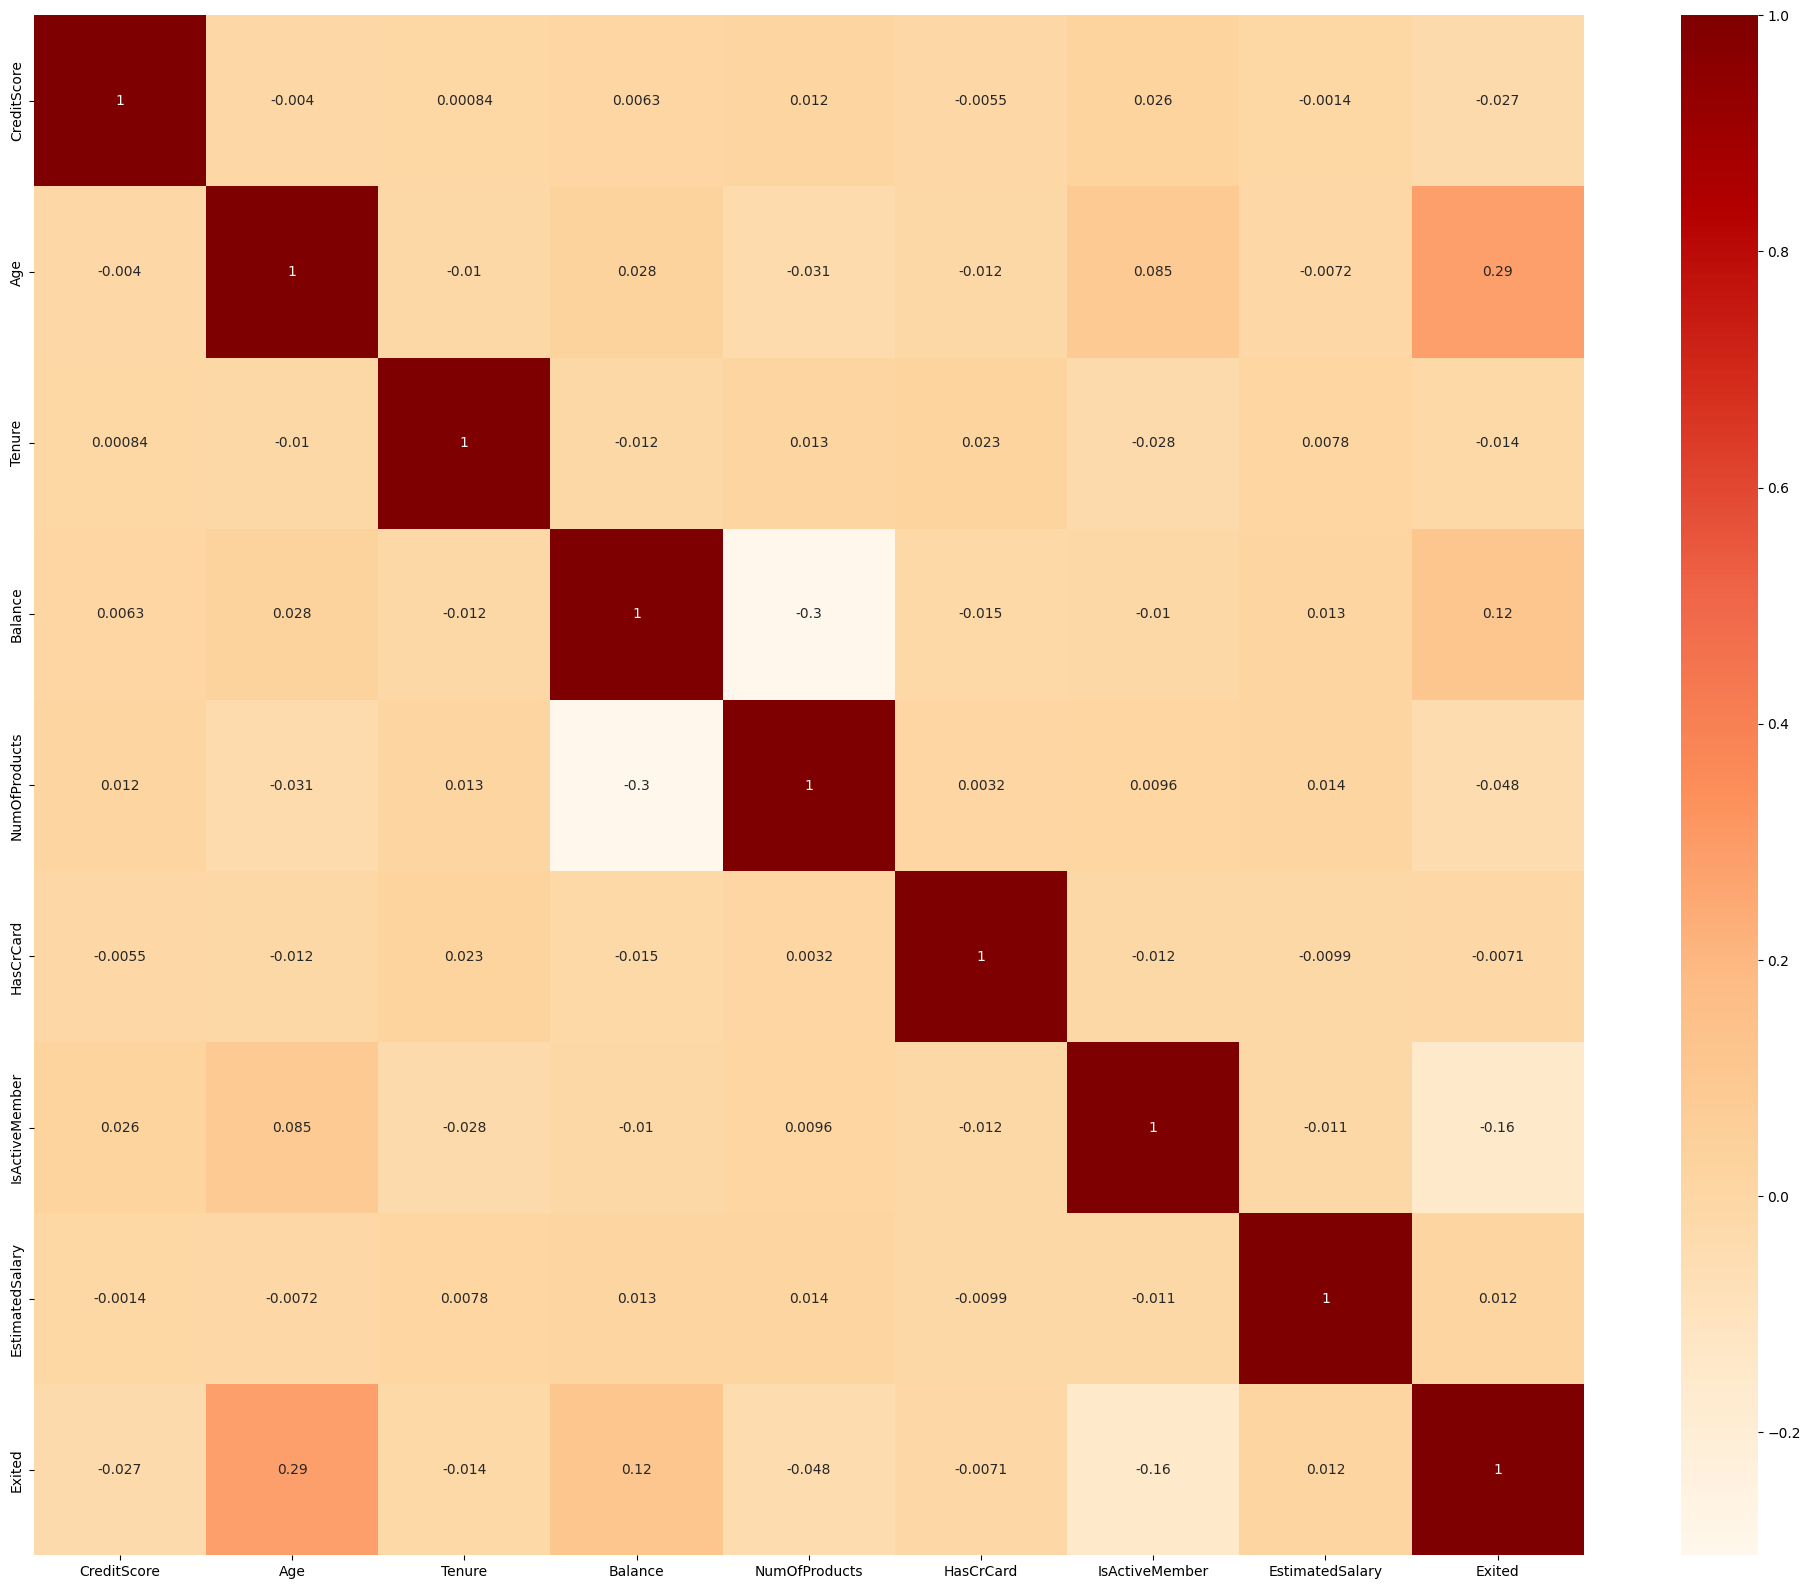

In [13]:
corr = df.corr()
plt.figure(figsize = (25,20))
sns.heatmap(corr, annot = True, cmap = 'OrRd')

We can see that none of the features are highly correlated to each other.

Then check distributions of the quantiative variables

In [13]:
quantitative

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

<Figure size 2000x1500 with 0 Axes>

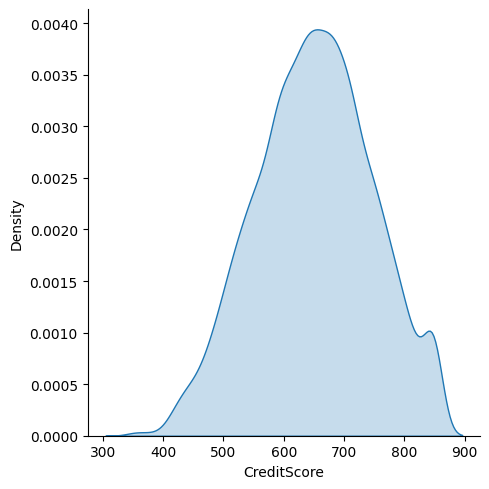

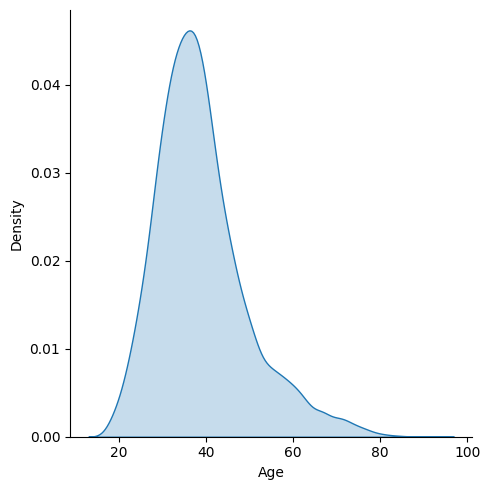

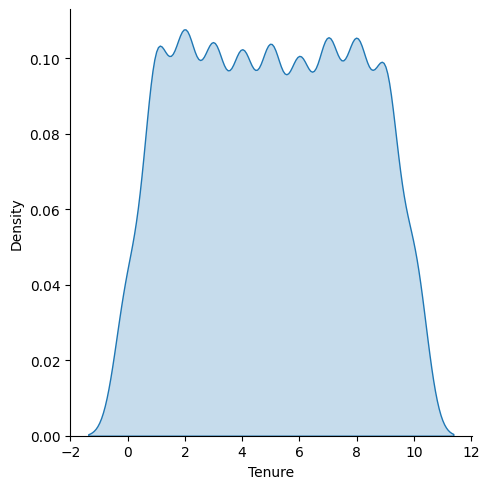

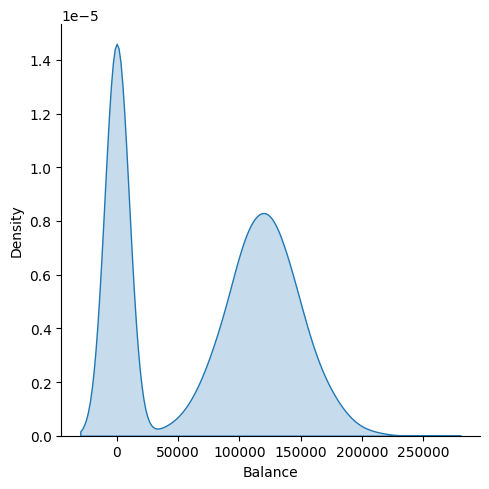

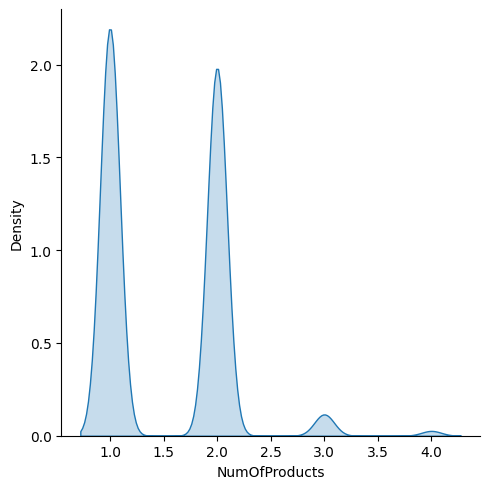

In [15]:
numeric_features= ['CreditScore','Age','Tenure','Balance','NumOfProducts']

fig = plt.figure(figsize = (20,15))
for i in range(len(numeric_features)):
    sns.displot(df, x=numeric_features[i] , kind="kde", fill=True)

### Dealing with categorical variables

For gender column, convert male to 1, and female to 0.<br>
Then for Geography, use pd.get_dummies for one-hot encoding

In [14]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [15]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


In [16]:
final_df = pd.get_dummies(df)

In [17]:
final_df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [18]:
final_df.shape

(10000, 13)

As a last step for preparing the data for modelling, split between training and testing set.

In [19]:
X = final_df.drop('Exited', axis = 1)
y = final_df['Exited']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

## Modeling

We are going to try to fit this using three different methods: logistic regression, XGBoost, Lightgbm, CatBoost.

### Logistic Regression

In [21]:
# fit the logistic regression model
clf_lg = LogisticRegressionCV(cv= 5,
                            random_state=42, 
                            scoring = 'roc_auc',
                            solver= 'newton-cholesky', 
                            n_jobs = 10,
                            verbose = 1,
                            class_weight = 'balanced').fit(X_train, y_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *



/Users/wootaekkim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.2325e-17): result may not be accurate.
  warnings.warn(
/Users/wootaekkim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing

RUNNING THE L-BFGS-B CODE

           * * *

RUNNING THE L-BFGS-B CODE

           * * *

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
Machine precision = 2.220D-16
   13      0      1      0     0     0   5.674D-06   5.806D-01

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
 N =           13     M =           10
Machine precision = 2.220D-16

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
 N =           13     M =           10
Tnint = total 

In [22]:
roc_auc_score(y_test, clf_lg.predict_proba(X_test)[:, 1])

0.788951065650042

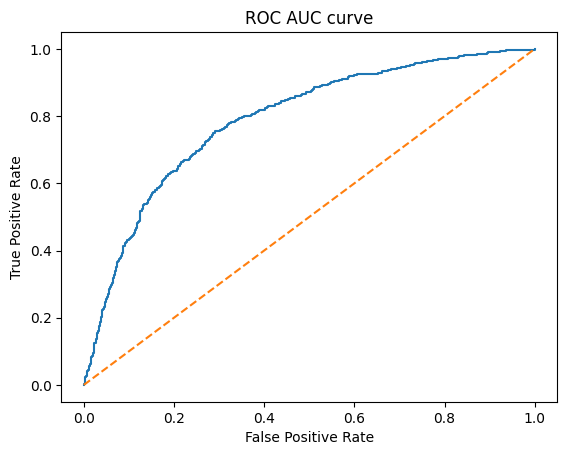

In [23]:
#create ROC curve
fpr1, tpr1, _ = roc_curve(y_test, clf_lg.predict_proba(X_test)[:, 1])

plt.plot(fpr1,tpr1)
plt.plot(np.linspace(0,1, num = 100),np.linspace(0,1, num = 100),linestyle = '--' )
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC curve')
plt.show()

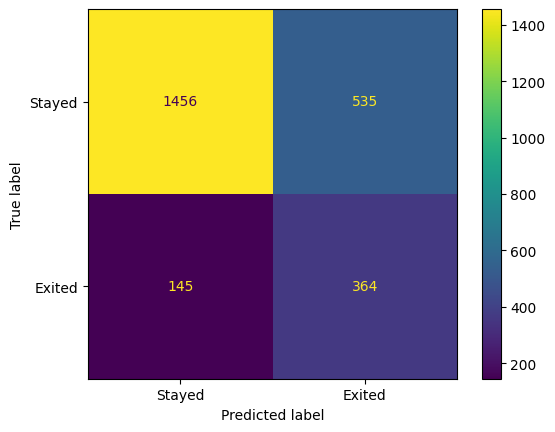

In [28]:
# create confusion matrix
conf_mat_lg =confusion_matrix(y_test,clf_lg.predict(X_test))

# plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat_lg,
                                            display_labels = ['Stayed', 'Exited'])

cm_display.plot()
plt.show()

Here Positive is Exited and Negative is Exited.<br>
From above we can see that True Positive Rate 71.5% and True Negative Rate is 73.5%. Here what we want to minimize is False Positive Rate which is 28.5%.<br>
<br>
This is because wrongly predicting exiting give less negative influence to the company. The loss we get from falsely giving customer extra service to the customer to make them stay would be better then loosing a customer. This does depends on how much it costs for the company usually invests on each customer who are about to leave. However, in general it would be much more loss as a company to loose a customer. <br>
<br>
Try other tree based models to see the difference

### XGBoost

Here we are going to use RandomimzedSearchCV for tuning hyperparameters

In [80]:
clf_xgb = xgb.sklearn.XGBClassifier(objective = 'binary:logistic',
                                    missing = 1, seed = 42)

In [81]:
params_1 = {'learning_rate' : [0.1, 0.01, 0.05],
           'max_depth' : [3, 4, 5],
           'reg_lambda': [0, 0.1, 0.3],
            'scale_pos_weight' :[1, 3, 5],
            'gamma' : [0, 0.1, 0.3, 0.5]
            }

In [47]:
grid_search1 = GridSearchCV(
    estimator=clf_xgb,
    param_grid=params_1,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=2
)
grid_search1.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=1, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'gamma': [0, 0.1, 0.3, 0.5],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5], 'reg_lambda': [0, 0.1, 0.3],
                         'scale_pos_weight': [1, 3, 5]},
             scoring='roc_auc', verbose=2)

In [49]:
grid_search1.best_params_

{'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 3,
 'reg_lambda': 0.3,
 'scale_pos_weight': 5}

In [50]:
params_2 = {'learning_rate' : [0.1,0,3, 0.5],
           'max_depth' : [3],
           'reg_lambda': [0.3, 0.4, 0.5],
            'gamma': [0.2, 0.3, 0.4],
            'scale_pos_weight' :[5, 6, 7],
            }

In [51]:
grid_search2 = GridSearchCV(
    estimator=clf_xgb,
    param_grid=params_2,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=2
)
grid_search2.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=1, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'gamma': [0.2, 0.3, 0.4],
                         'learning_rate': [0.1, 0, 3, 0.5], 'max_depth': [3],
                         'reg_lambda': [0.3, 0.4, 0.5],
                         'scale_pos_weight': [5, 6, 7]},
             scoring='roc_auc', verbose=2)

[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.3, scale_pos_weight=6; total time=   2.2s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.5, scale_pos_weight=6; total time=   2.0s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.3, scale_pos_weight=5; total time=   2.2s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.3, scale_pos_weight=7; total time=   2.0s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.4, scale_pos_weight=6; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.5, scale_pos_weight=5; total time=   2.2s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.5, scale_pos_weight=7; total time=   2.2s
[CV] END gamma=0.2, learning_rate=3, max_depth=3, reg_lambda=0.4, scale_pos_weight=5; total time=   1.4s
[CV] END gamma=0.2, learning_rate=3, max_depth=3, reg_lambda=0.4, scale_pos_weight=7; total time=   0.9s
[CV] END gamma=0.2, learning_rate=3, max_depth=3, r

[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.3, scale_pos_weight=5; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.4, scale_pos_weight=5; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.4, scale_pos_weight=7; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.5, scale_pos_weight=5; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.5, scale_pos_weight=7; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.3, scale_pos_weight=6; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.4, scale_pos_weight=5; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.4, scale_pos_weight=7; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.5, scale_pos_weight=6; total time=   2.1s
[CV] END gamma=0.2, learning_rate=3, max_dept

[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.3, scale_pos_weight=6; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.4, scale_pos_weight=5; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.4, scale_pos_weight=6; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.5, scale_pos_weight=5; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.5, scale_pos_weight=7; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.3, scale_pos_weight=6; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.4, scale_pos_weight=5; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.4, scale_pos_weight=7; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.5, scale_pos_weight=6; total time=   2.1s
[CV] END gamma=0.2, learning_rate=3, max_dept

[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.3, scale_pos_weight=6; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.4, scale_pos_weight=5; total time=   2.0s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.4, scale_pos_weight=6; total time=   2.2s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.5, scale_pos_weight=6; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.3, scale_pos_weight=5; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.3, scale_pos_weight=7; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.4, scale_pos_weight=6; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.5, scale_pos_weight=5; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.5, scale_pos_weight=6; total time=   2.0s
[CV] END gamma=0.2, learning_rate=3, max_depth=

[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.3, scale_pos_weight=6; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.3, scale_pos_weight=7; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.4, scale_pos_weight=7; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.5, scale_pos_weight=5; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, reg_lambda=0.5, scale_pos_weight=7; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.3, scale_pos_weight=6; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.4, scale_pos_weight=5; total time=   2.0s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.4, scale_pos_weight=7; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0, max_depth=3, reg_lambda=0.5, scale_pos_weight=6; total time=   2.1s
[CV] END gamma=0.2, learning_rate=3, max_dept

In [52]:
grid_search2.best_params_

{'gamma': 0.4,
 'learning_rate': 0.1,
 'max_depth': 3,
 'reg_lambda': 0.3,
 'scale_pos_weight': 5}

In [35]:
params_3 = {'learning_rate' : [0.1],
           'max_depth' : [3],
           'reg_lambda': [0.3],
            'gamma': [0.4],
            'scale_pos_weight' :[5]
            }

In [53]:
clf_xgb_new = xgb.sklearn.XGBClassifier(objective = 'binary:logistic',
                                    missing = 1,
                                    seed = 42,
                                   learning_rate = 0.1, 
                                   max_depth = 3,
                                   reg_lambda = 0.3,
                                   scale_pos_weight =5,
                                    gamma = 0.4)
clf_xgb_new.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=1, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [54]:
roc_auc_score(y_test, clf_xgb_new.predict_proba(X_test)[:, 1])

0.8769033341589214

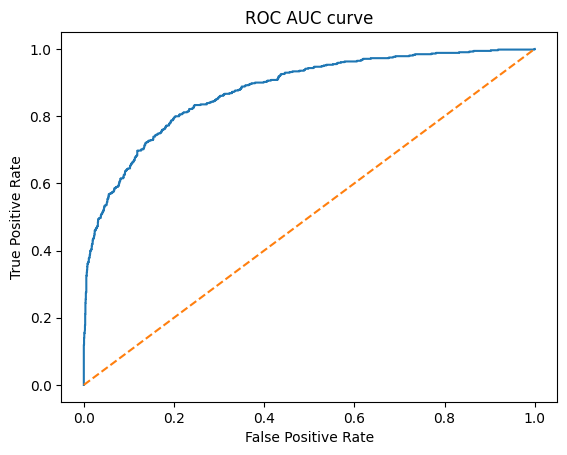

In [55]:
fpr2, tpr2, _ = roc_curve(y_test, clf_xgb_new.predict_proba(X_test)[:, 1])

plt.plot(fpr2,tpr2)
plt.plot(np.linspace(0,1, num = 100),np.linspace(0,1, num = 100),linestyle = '--' )
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC curve')
plt.show()

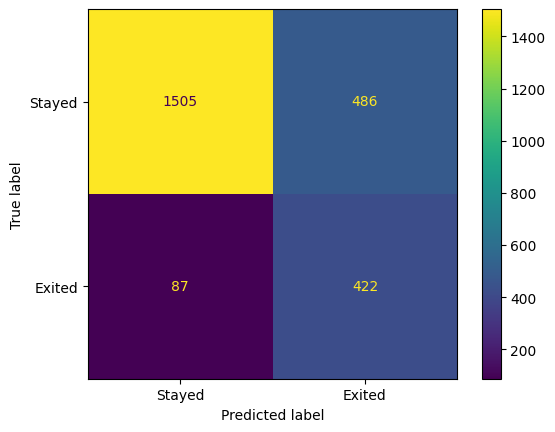

In [73]:
# create confusion matrix
conf_mat_xgb =confusion_matrix(y_test,clf_xgb_new.predict(X_test))

# plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat_xgb,
                                            display_labels = ['Stayed', 'Exited'])

cm_display.plot()
plt.show()

Here we can see that False Positive Rate is 17.1%. Compared to Logistic regression model above, it has improved alot. Check other alogirithms to see if they do the better job.

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

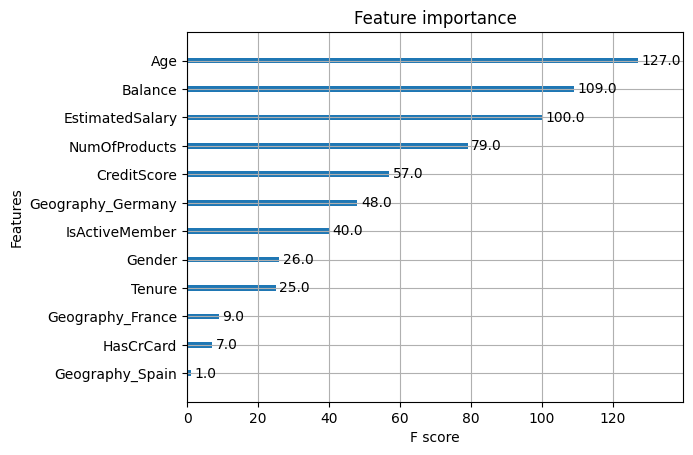

In [57]:
xgb.plot_importance(clf_xgb_new)

Gradient Boost Classifier

In [166]:
clf_gb = GradientBoostingClassifier(random_state = 42)

In [167]:
params_4 = {
    'max_leaf_nodes' : [50, 100, 150, 200],
    'learning_rate' : [0.01, 0.001, 0.1, 1],
    'max_features':['log2','sqrt'],
    'min_samples_split': [0.1, 0.3, 0.5, 0.8],
    'min_samples_leaf': [10, 30, 50, 80, 100]
}

In [172]:
rand_search4 =RandomizedSearchCV(
    clf_gb,
    params_4,
    n_jobs = 10,
    scoring = 'roc_auc',
    cv = 5,
    verbose=1,
)
rand_search4.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_jobs=10,
                   param_distributions={'learning_rate': [0.01, 0.001, 0.1, 1],
                                        'max_features': ['log2', 'sqrt'],
                                        'max_leaf_nodes': [50, 100, 150, 200],
                                        'min_samples_leaf': [10, 30, 50, 80,
                                                             100],
                                        'min_samples_split': [0.1, 0.3, 0.5,
                                                              0.8]},
                   scoring='roc_auc', verbose=1)

In [173]:
rand_search4.best_params_

{'min_samples_split': 0.1,
 'min_samples_leaf': 30,
 'max_leaf_nodes': 200,
 'max_features': 'sqrt',
 'learning_rate': 0.1}

In [174]:
params_5 = {
    'max_leaf_nodes' : [180, 200, 220, 250],
    'learning_rate' : [0.05, 0.08, 0.1, 0.3, 0.5,],
    'max_features':['sqrt'],
    'min_samples_split': [0.1,0.08, 0.05],
    'min_samples_leaf': [20, 30,40]
}

In [175]:
rand_search5 =RandomizedSearchCV(
    clf_gb,
    params_5,
    n_jobs = 10,
    scoring = 'roc_auc',
    cv = 5,
    verbose=1,
)
rand_search5.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_jobs=10,
                   param_distributions={'learning_rate': [0.05, 0.08, 0.1, 0.3,
                                                          0.5],
                                        'max_features': ['sqrt'],
                                        'max_leaf_nodes': [180, 200, 220, 250],
                                        'min_samples_leaf': [20, 30, 40],
                                        'min_samples_split': [0.1, 0.08, 0.05]},
                   scoring='roc_auc', verbose=1)

In [176]:
rand_search5.best_params_

{'min_samples_split': 0.08,
 'min_samples_leaf': 40,
 'max_leaf_nodes': 250,
 'max_features': 'sqrt',
 'learning_rate': 0.1}

In [177]:
params_6 = {
    'max_leaf_nodes' : [240, 250, 275, 300],
    'learning_rate' : [0.1],
    'max_features':['sqrt'],
    'min_samples_split': [0.08],
    'min_samples_leaf': [40, 50, 80, 100]
}

In [178]:
grid_search6 = GridSearchCV(
    estimator=clf_gb,
    param_grid=params_6,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=2
)
grid_search6.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=10,
             param_grid={'learning_rate': [0.1], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [240, 250, 275, 300],
                         'min_samples_leaf': [40, 50, 80, 100],
                         'min_samples_split': [0.08]},
             scoring='roc_auc', verbose=2)

In [179]:
grid_search6.best_params_

{'learning_rate': 0.1,
 'max_features': 'sqrt',
 'max_leaf_nodes': 240,
 'min_samples_leaf': 40,
 'min_samples_split': 0.08}

In [181]:
clf_gb_new = GradientBoostingClassifier(random_state = 42,
                                   learning_rate = 0.1,
                                   max_features = 'sqrt',
                                   max_leaf_nodes =240,
                                   min_samples_leaf = 40,
                                   min_samples_split = 0.08)
clf_gb_new.fit(X_train, y_train)

GradientBoostingClassifier(max_features='sqrt', max_leaf_nodes=240,
                           min_samples_leaf=40, min_samples_split=0.08,
                           random_state=42)

In [182]:
roc_auc_score(y_test, clf_gb_new.predict_proba(X_test)[:, 1])

0.8775787704789432

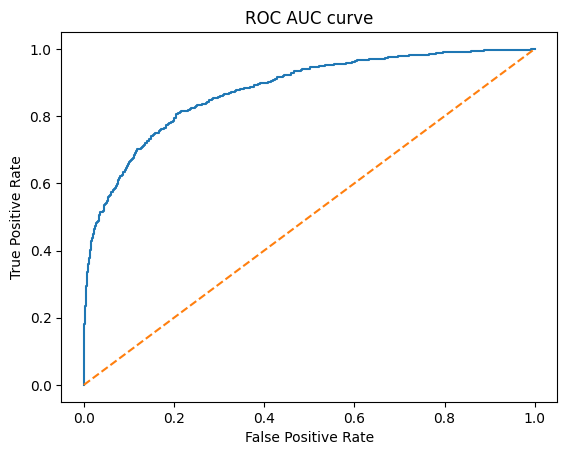

In [183]:
fpr3, tpr3, _ = roc_curve(y_test, clf_gb_new.predict_proba(X_test)[:, 1])

plt.plot(fpr3,tpr3)
plt.plot(np.linspace(0,1, num = 100),np.linspace(0,1, num = 100),linestyle = '--' )
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC curve')
plt.show()

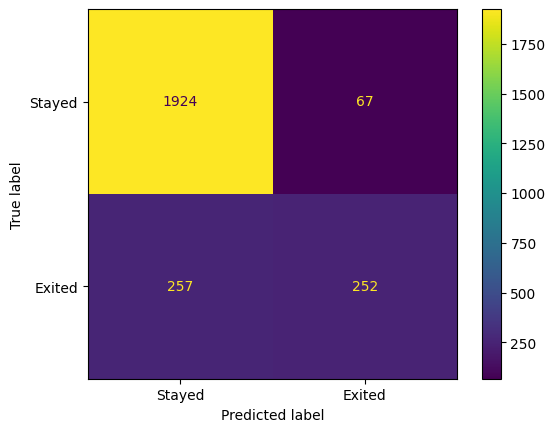

[CV] END learning_rate=0.1, max_features=sqrt, max_leaf_nodes=240, min_samples_leaf=40, min_samples_split=0.08; total time=   1.8s
[CV] END learning_rate=0.1, max_features=sqrt, max_leaf_nodes=240, min_samples_leaf=100, min_samples_split=0.08; total time=   1.5s
[CV] END learning_rate=0.1, max_features=sqrt, max_leaf_nodes=250, min_samples_leaf=40, min_samples_split=0.08; total time=   1.5s
[CV] END learning_rate=0.1, max_features=sqrt, max_leaf_nodes=250, min_samples_leaf=80, min_samples_split=0.08; total time=   1.5s
[CV] END learning_rate=0.1, max_features=sqrt, max_leaf_nodes=275, min_samples_leaf=40, min_samples_split=0.08; total time=   1.5s
[CV] END learning_rate=0.1, max_features=sqrt, max_leaf_nodes=275, min_samples_leaf=80, min_samples_split=0.08; total time=   1.4s
[CV] END learning_rate=0.1, max_features=sqrt, max_leaf_nodes=300, min_samples_leaf=40, min_samples_split=0.08; total time=   1.5s
[CV] END learning_rate=0.1, max_features=sqrt, max_leaf_nodes=300, min_samples_lea

[CV] END learning_rate=0.1, max_features=sqrt, max_leaf_nodes=240, min_samples_leaf=50, min_samples_split=0.08; total time=   1.7s
[CV] END learning_rate=0.1, max_features=sqrt, max_leaf_nodes=240, min_samples_leaf=80, min_samples_split=0.08; total time=   1.6s
[CV] END learning_rate=0.1, max_features=sqrt, max_leaf_nodes=250, min_samples_leaf=50, min_samples_split=0.08; total time=   1.4s
[CV] END learning_rate=0.1, max_features=sqrt, max_leaf_nodes=250, min_samples_leaf=100, min_samples_split=0.08; total time=   1.5s
[CV] END learning_rate=0.1, max_features=sqrt, max_leaf_nodes=275, min_samples_leaf=50, min_samples_split=0.08; total time=   1.5s
[CV] END learning_rate=0.1, max_features=sqrt, max_leaf_nodes=275, min_samples_leaf=100, min_samples_split=0.08; total time=   1.4s
[CV] END learning_rate=0.1, max_features=sqrt, max_leaf_nodes=300, min_samples_leaf=50, min_samples_split=0.08; total time=   1.5s
[CV] END learning_rate=0.1, max_features=sqrt, max_leaf_nodes=300, min_samples_le

In [185]:
# create confusion matrix
conf_mat_gb =confusion_matrix(y_test,clf_gb_new.predict(X_test))

# plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat_gb,
                                            display_labels = ['Stayed', 'Exited'])

cm_display.plot()
plt.show()

### LightGBM

In [58]:
clf_lgbm = LGBMClassifier(objective = 'binary',
                         random_state =42)

In [62]:
params_7 = {
    'learning_rate' : [0.1, 0.01, 0.05],
    'max_depth' :[3,4,5],
    'min_data_in_leaf' :[20,35, 50],
    'min_split_gain' : [0.01, 0.1 ,0.05],    
}

In [63]:
rand_search7 =RandomizedSearchCV(
    clf_lgbm,
    params_7,
    n_jobs = 10,
    scoring = 'roc_auc',
    cv = 5,
    verbose=1,
)
rand_search7.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(objective='binary',
                                            random_state=42),
                   n_jobs=10,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.05],
                                        'max_depth': [3, 4, 5],
                                        'min_data_in_leaf': [20, 35, 50],
                                        'min_split_gain': [0.01, 0.1, 0.05]},
                   scoring='roc_auc', verbose=1)

In [64]:
rand_search7.best_params_

{'min_split_gain': 0.01,
 'min_data_in_leaf': 35,
 'max_depth': 5,
 'learning_rate': 0.05}

In [187]:
params_8 = {
    'learning_rate' : [0.03, 0.05, 0.07],
    'max_depth' :[5,7, 10],
    'min_data_in_leaf' :[30,35,40],
    'min_split_gain' : [0.01,0.03],    
}

In [188]:
grid_search8 = GridSearchCV(
    estimator=clf_lgbm,
    param_grid=params_8,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=2
)
grid_search8.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


GridSearchCV(cv=5,
             estimator=LGBMClassifier(objective='binary', random_state=42),
             n_jobs=10,
             param_grid={'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 7, 10],
                         'min_data_in_leaf': [30, 35, 40],
                         'min_split_gain': [0.01, 0.03]},
             scoring='roc_auc', verbose=2)

In [189]:
grid_search8.best_params_

{'learning_rate': 0.05,
 'max_depth': 5,
 'min_data_in_leaf': 40,
 'min_split_gain': 0.01}

In [190]:
clf_lgbm_new = LGBMClassifier(objective = 'binary',
                         random_state =42,
                         min_split_gain = 0.01, 
                         min_data_in_leaf= 40,
                         max_depth = 5,
                         learning_rate = 0.05)
clf_lgbm_new.fit(X_train, 
                 y_train)

LGBMClassifier(learning_rate=0.05, max_depth=5, min_data_in_leaf=40,
               min_split_gain=0.01, objective='binary', random_state=42)

In [191]:
roc_auc_score(y_test, clf_lgbm_new.predict_proba(X_test)[:, 1])

0.8778777583605597

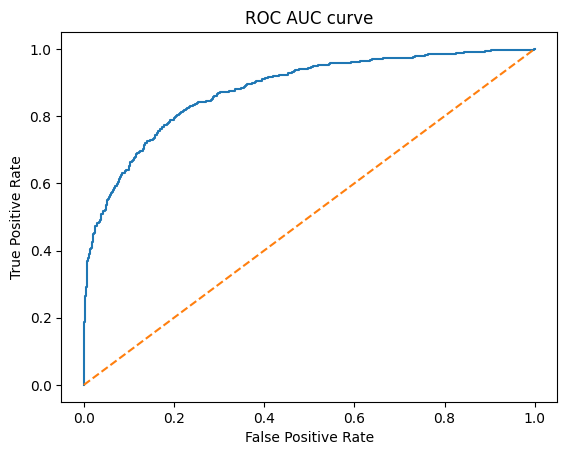

In [192]:
fpr4, tpr4, _ = roc_curve(y_test, clf_lgbm_new.predict_proba(X_test)[:, 1])

plt.plot(fpr4,tpr4)
plt.plot(np.linspace(0,1, num = 100),np.linspace(0,1, num = 100),linestyle = '--' )
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC curve')
plt.show()

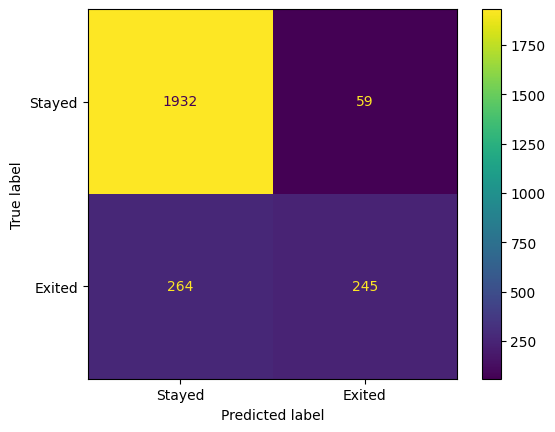

In [193]:
# create confusion matrix
conf_mat_lgbm =confusion_matrix(y_test, clf_lgbm_new.predict(X_test))

# plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat_lgbm,
                                            display_labels = ['Stayed', 'Exited'])

cm_display.plot()
plt.show()

From above, we can see that False Positive Rate is 54.6% which is even higher than 50%. Therefore, try other model which has lower FPR.

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

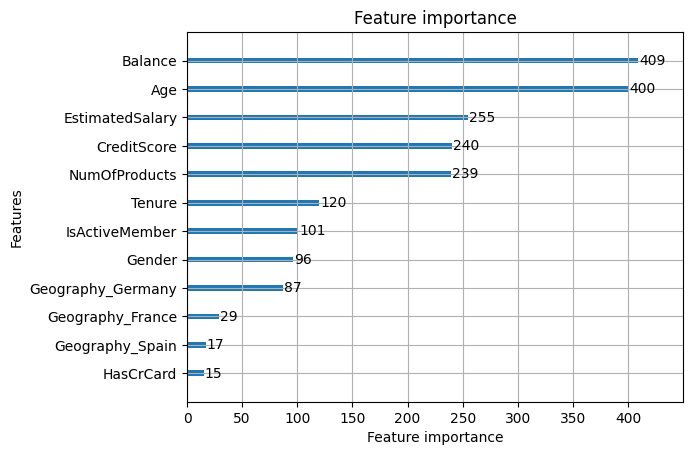

In [194]:
lightgbm.plot_importance(clf_lgbm_new)

### AdaBoost

In [99]:
clf_ada = AdaBoostClassifier(random_state =42)

In [100]:
params_9 = {
    'n_estimators' : [10, 50, 100, 500],
    'learning_rate' :[0.0001, 0.001, 0.01, 0.1, 1.0],  
}

In [101]:
rand_search9 =RandomizedSearchCV(
    clf_ada,
    params_9,
    n_jobs = 10,
    scoring = 'roc_auc',
    cv = 5,
    verbose=1,
)
rand_search9.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
                   n_jobs=10,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1.0],
                                        'n_estimators': [10, 50, 100, 500]},
                   scoring='roc_auc', verbose=1)

In [102]:
rand_search9.best_params_

{'n_estimators': 500, 'learning_rate': 0.1}

In [103]:
params_10 = {
    'n_estimators' : [300, 400, 500, 600, 700],
    'learning_rate' :[ 0.05 ,0.07, 0.1, 0.3, 0.5],  
}

In [104]:
grid_search10 =GridSearchCV(
    clf_ada,
    params_10,
    n_jobs = 10,
    scoring = 'roc_auc',
    cv = 5,
    verbose=1,
)
grid_search10.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42), n_jobs=10,
             param_grid={'learning_rate': [0.05, 0.07, 0.1, 0.3, 0.5],
                         'n_estimators': [300, 400, 500, 600, 700]},
             scoring='roc_auc', verbose=1)

In [105]:
grid_search10.best_params_

{'learning_rate': 0.05, 'n_estimators': 400}

In [106]:
params_11 = {
    'n_estimators' : [350, 370, 400, 430, 450],
    'learning_rate' :[ 0.05, 0.06],  
}

In [107]:
grid_search11 =GridSearchCV(
    clf_ada,
    params_11,
    n_jobs = 10,
    scoring = 'roc_auc',
    cv = 5,
    verbose=1,
)
grid_search11.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42), n_jobs=10,
             param_grid={'learning_rate': [0.05, 0.06],
                         'n_estimators': [350, 370, 400, 430, 450]},
             scoring='roc_auc', verbose=1)

In [108]:
grid_search11.best_params_

{'learning_rate': 0.05, 'n_estimators': 370}

In [132]:
clf_ada_new = AdaBoostClassifier(random_state =42,
                            learning_rate = 0.05,
                            n_estimators = 370)
clf_ada_new.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.05, n_estimators=370, random_state=42)

In [133]:
roc_auc_score(y_test, clf_ada_new.predict_proba(X_test)[:, 1])

0.862528727012223

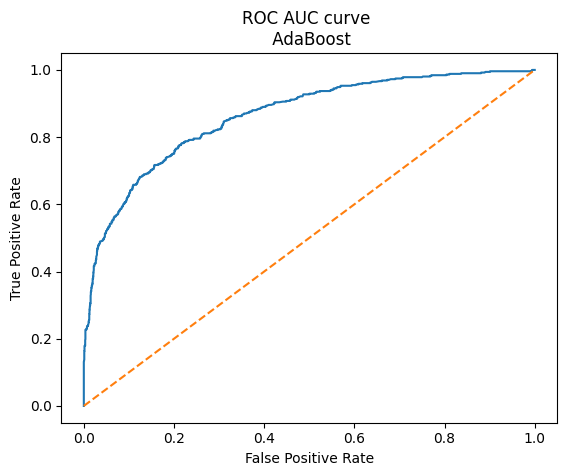

In [134]:
fpr5, tpr5, _ = roc_curve(y_test, clf_ada_new.predict_proba(X_test)[:, 1])

plt.plot(fpr5,tpr5)
plt.plot(np.linspace(0,1, num = 100),np.linspace(0,1, num = 100),linestyle = '--' )
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC curve \n AdaBoost')
plt.show()

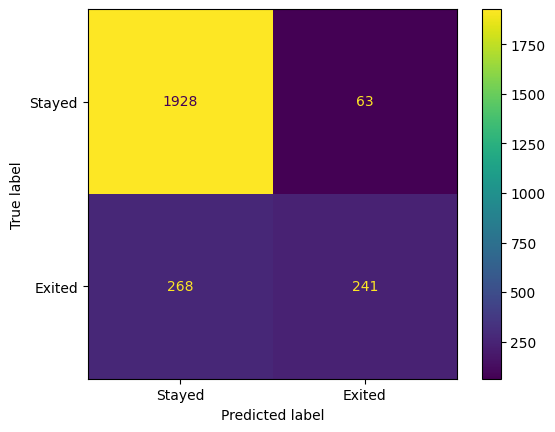

In [135]:
# create confusion matrix
conf_mat_ada =confusion_matrix(y_test, clf_new_ada.predict(X_test))

# plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat_ada,
                                            display_labels = ['Stayed', 'Exited'])

cm_display.plot()
plt.show()

Like LightGBM Classifier, here we have high False Positive Rate of 52.6%. Therefore, try other model to find model with low FPR.

### Stacked Model

In [226]:
stacked_model = StackingCVClassifier(classifiers=(clf_lg,clf_xgb_new),
                                    meta_classifier=clf_xgb_new, use_features_in_secondary=True)

In [227]:
stacked_model.fit(X_train,y_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
/Users/wootaekkim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=4.46212e-17): result may not be accurate.
  warnings.warn(
/Users/wootaekkim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13      0      1      0     0     0   1.995D-05   5.808D-01

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

           * 

/Users/wootaekkim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=4.43589e-17): result may not be accurate.
  warnings.warn(
 This problem is unconstrained.
/Users/wootaekkim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first plac

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13      0      1      0     0     0   2.139D-05   5.839D-01

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active

/Users/wootaekkim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=4.56697e-17): result may not be accurate.
  warnings.warn(
 This problem is unconstrained.
/Users/wootaekkim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first plac

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13      0      1      0     0     0   2.382D-05   5.764D-01

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
/Users/wootaekkim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.257e-17): result may not be accurate.
  warnings.warn(
 This problem is unconstrained.
/Users/wootaekkim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further opt

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13      0      1      0     0     0   5.674D-06   5.806D-01

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active

/Users/wootaekkim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.2035e-17): result may not be accurate.
  warnings.warn(
 This problem is unconstrained.
/Users/wootaekkim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13      0      1      0     0     0   5.053D-06   5.828D-01

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active

StackingCVClassifier(classifiers=(LogisticRegressionCV(class_weight='balanced',
                                                       cv=5, n_jobs=10,
                                                       random_state=42,
                                                       scoring='roc_auc',
                                                       solver='newton-cholesky',
                                                       verbose=1),
                                  XGBClassifier(base_score=None, booster=None,
                                                callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                eval_metr...
                                                   importance_type=None,
                                                   interaction_constraints=None,
                                                   learning_rate=0.1,
                                                   max_bin=None,
                                                   max_cat_threshold=None,
                                                   max_cat_to_onehot=None,
                                                   max_delta_step=None,
                                                   max_depth=3, max_leaves=None,
                                                   min_child_weight=None,
                                                   missing=1,
                                                   monotone_constraints=None,
                                                   n_estimators=100,
                                                   n_jobs=None,
                                                   num_parallel_tree=None,
                                                   predictor=None,
                                                   random_state=None, ...),
                     use_features_in_secondary=True)

In [228]:
roc_auc_score(y_test, stacked_model.predict_proba(X_test)[:, 1])

0.8763142392238551

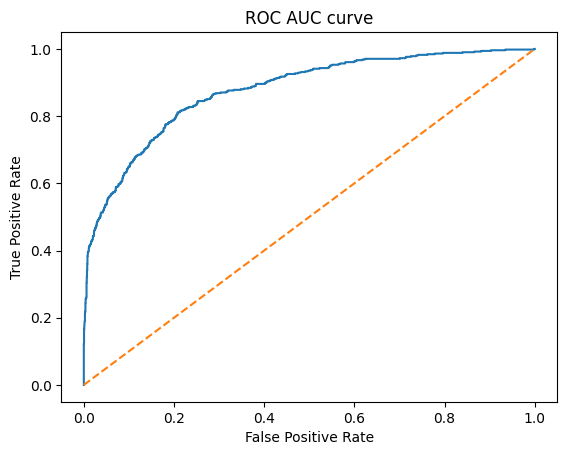

In [229]:
fpr6, tpr6, _ = roc_curve(y_test, stacked_model.predict_proba(X_test)[:, 1])

plt.plot(fpr6,tpr6)
plt.plot(np.linspace(0,1, num = 100),np.linspace(0,1, num = 100),linestyle = '--' )
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC curve')
plt.show()

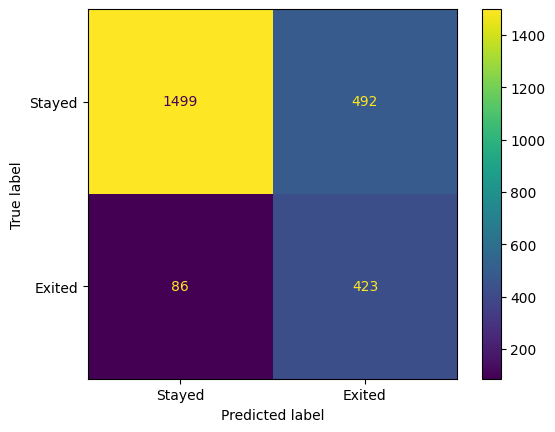

In [231]:
# create confusion matrix
conf_mat_stkd =confusion_matrix(y_test, stacked_model.predict(X_test))

# plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat_stkd,
                                            display_labels = ['Stayed', 'Exited'])

cm_display.plot()
plt.show()

Here we have False Positive Rate of 16.8%. Even with lower auc roc score compared to XGBoost Classifier, this would be considered a better classifier in this case as our Stacked model classifier has lower False Positive Rate.